# Create dataset

In [48]:
from PIL import Image
import glob
import os.path
import re

base_dir = 'c:/clustering/dataset/' # images are expected to be in subfolders of this folder (no nested subfolders)
resized_suffix = '_resized'

size = (240, 240)
images = []
labels = []
for filename in glob.glob(base_dir + '*/*.jpg'):
    if resized_suffix in filename: continue # make sure we don't process the files we already resized
    resized_filename = os.path.splitext(filename)[0] + resized_suffix + '.jpg'
    if not os.path.isfile(resized_filename):
        image = Image.open(filename)
        image.thumbnail(size, Image.ANTIALIAS)
        image.save(resized_filename, "JPEG")
    images.append(Image.open(resized_filename))
    labels.append(re.split("[/\\\]", filename)[-2])

print("prepared " + str(len(images)) + " images")

prepared 243 images


# Extract Features

In [415]:
import numpy as np
X = np.ones(shape=(len(images), 0)) # initialize feature matrix X
X.shape

(229, 0)

In [61]:
sample_images = [3, 13, 52, 151, 212]

## HSV histogram

(229, 1370)

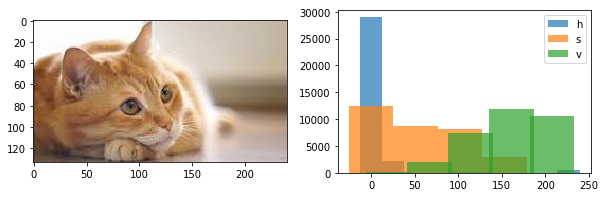

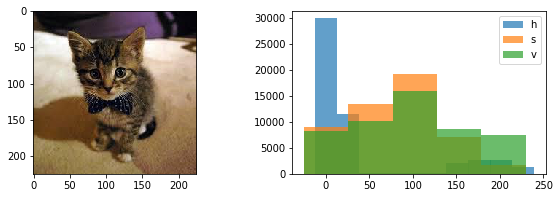

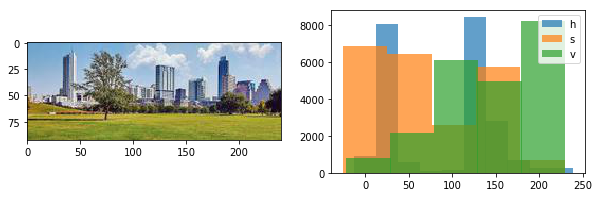

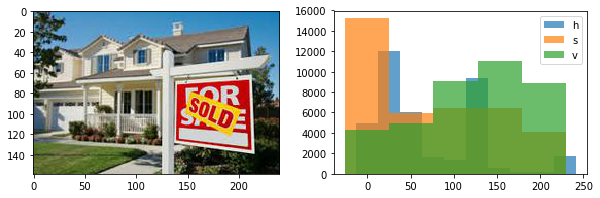

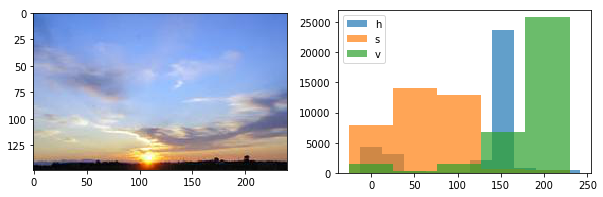

In [446]:
import matplotlib.pyplot as plt
%matplotlib inline

bins_h = 10
bins_s = 5
bins_v = 5
n_features = bins_h + bins_s + bins_v
features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

for i, image in enumerate(images):
    hsv = image.convert('HSV');
    h_hist, h_bins = np.histogram(hsv.getchannel('H'), bins=bins_h)
    s_hist, s_bins = np.histogram(hsv.getchannel('S'), bins=bins_s)
    v_hist, v_bins = np.histogram(hsv.getchannel('V'), bins=bins_v)
    features[i] = np.concatenate([h_hist, s_hist, v_hist])
    if i in sample_images:
        plt.figure(figsize=(10, 3))
        plt.subplot(121)
        plt.imshow(image)
        plt.subplot(122)
        plt.bar(h_bins[:-1], h_hist, alpha=.7, label='h', width=255/bins_h)
        plt.bar(s_bins[:-1], s_hist, alpha=.7, label='s', width=255/bins_s)
        plt.bar(v_bins[:-1], v_hist, alpha=.7, label='v', width=255/bins_v)
        plt.legend()        

X = np.column_stack((X, features)) # add new features to feature matrix X
X.shape

### RGB Histogram

(229, 1400)

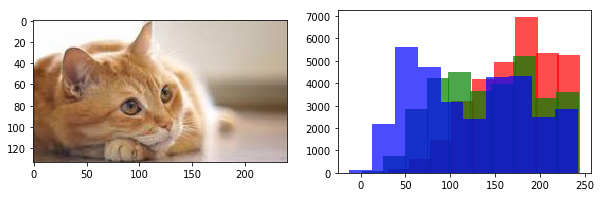

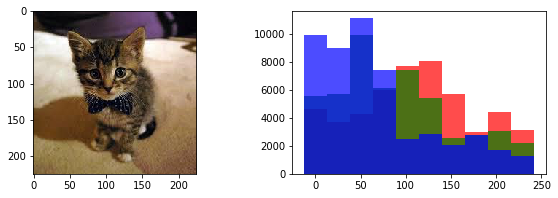

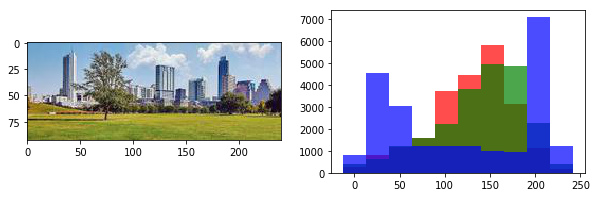

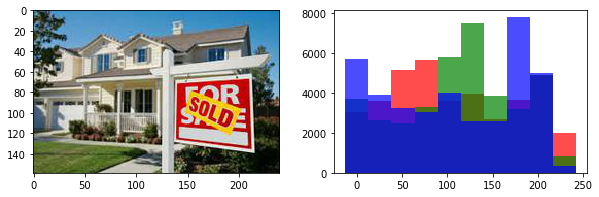

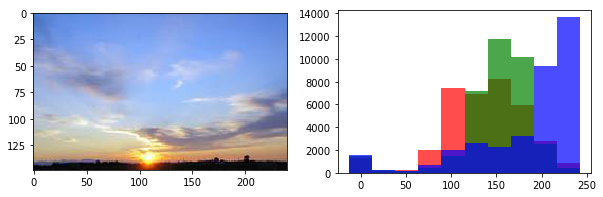

In [447]:
import matplotlib.pyplot as plt
%matplotlib inline

bins_r = 10
bins_g = 10
bins_b = 10
n_features = bins_r + bins_g + bins_b
features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

for i, image in enumerate(images):
    r_hist, r_bins = np.histogram(image.getchannel('R'), bins=bins_r)
    g_hist, g_bins = np.histogram(image.getchannel('G'), bins=bins_g)
    b_hist, b_bins = np.histogram(image.getchannel('B'), bins=bins_b)
    features[i] = np.concatenate([r_hist, g_hist, b_hist])
    if i in sample_images:
        plt.figure(figsize=(10,3))
        plt.subplot(121)
        plt.imshow(image)
        plt.subplot(122)
        plt.bar(r_bins[:-1], r_hist, alpha=.7, color='r', width=255/bins_r)
        plt.bar(g_bins[:-1], g_hist, alpha=.7, color='g', width=255/bins_g)
        plt.bar(b_bins[:-1], b_hist, alpha=.7, color='b', width=255/bins_g)

X = np.column_stack((X, features)) # add new features to feature matrix X
X.shape

## Edge histogram

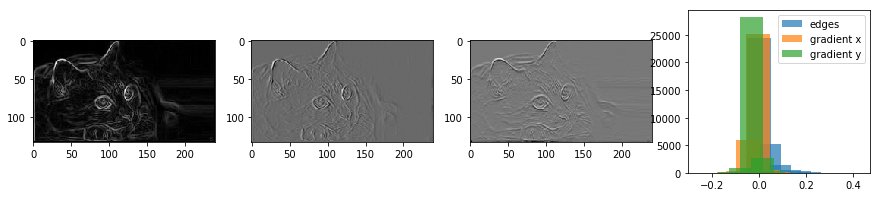

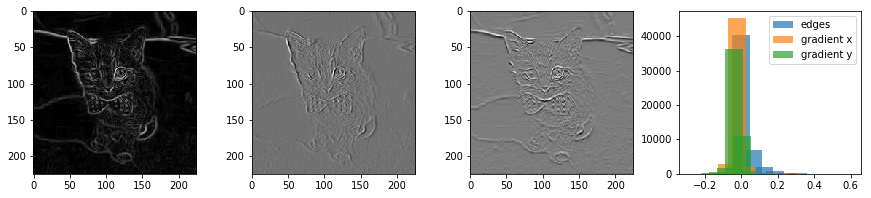

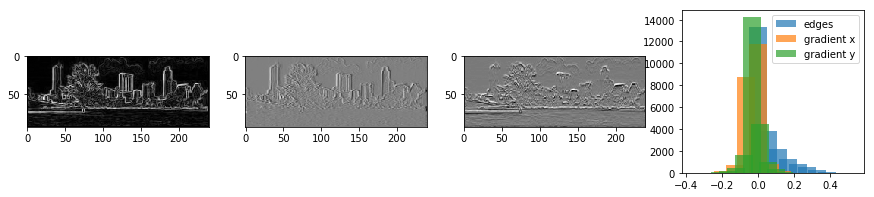

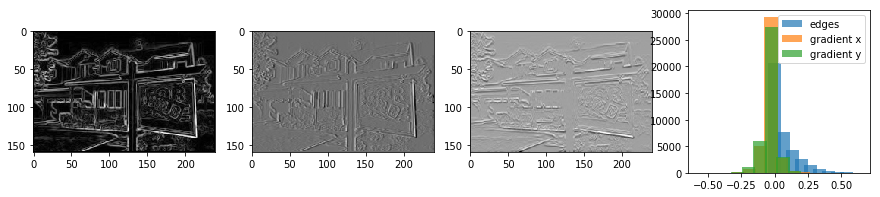

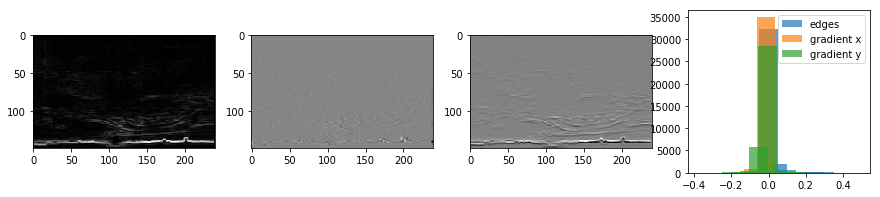

In [448]:
from skimage.filters import sobel

# TODO: sub-sample the image and dont count bins for 0-values

n_features = 10
features = np.ones(shape=(len(images), n_features*2)) # initialize feature matrix

for i, image in enumerate(images):
    edges = sobel(image.convert('HSV').getchannel('V'))
    hist, bins = np.histogram(edges, bins=n_features)
    grad_y, grad_x = np.gradient(edges)
    hist_x, bins_x = np.histogram(grad_x, bins=n_features)
    hist_y, bins_y = np.histogram(grad_y, bins=n_features)
    features[i] = np.append(hist_x, hist_y)                
    if i in sample_images:
        plt.figure(figsize=(15, 3))
        plt.subplot(141)
        plt.imshow(edges, cmap='gray')
        plt.subplot(142)
        plt.imshow(grad_x, cmap='gray')
        plt.subplot(143)
        plt.imshow(grad_y, cmap='gray')
        plt.subplot(144)
        plt.bar(bins[:-1], hist, alpha=.7, label='edges', width=0.1) # use the gradients or magnitues?
        plt.bar(bins_x[:-1], hist_x, alpha=.7, label='gradient x', width=0.1)
        plt.bar(bins_y[:-1], hist_y, alpha=.7, label='gradient y', width=0.1)
        plt.legend()
        #print(grad_x)

X = np.column_stack((X, features)) # add new features to feature matrix X

### Custom edge calculation

[11320.  1965.  4657.  2657.  1360.  5469.  1270.  2779.]
[12444.  4837.  9643.  3535.  3134.  7008.  2807.  5493.]
[3307. 2042. 2939. 2255. 2172. 3153. 2086. 2823.]
[6090. 3160. 4897. 4119. 3064. 6749. 3068. 4874.]
[8080. 2188. 4286. 4232. 2068. 8281. 1973. 3585.]


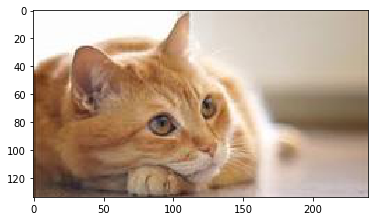

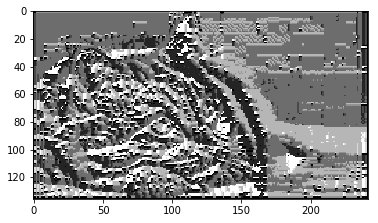

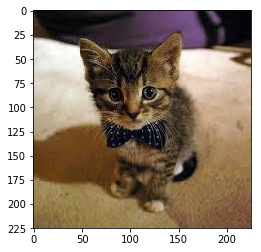

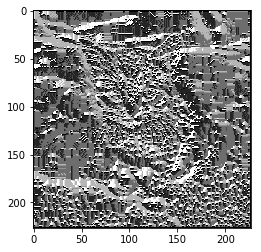

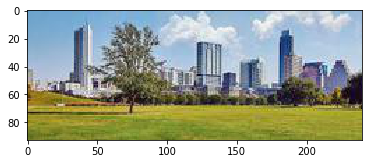

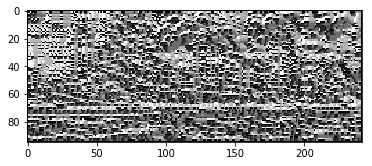

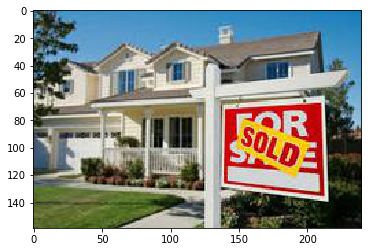

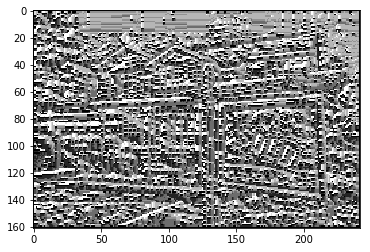

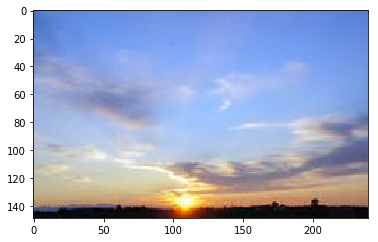

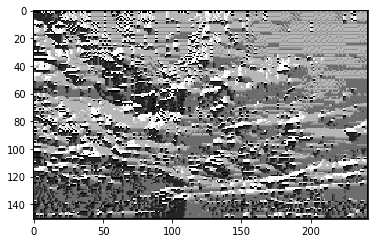

In [450]:
import math

n_features = 8 # one for each direction
features = np.ones(shape=(len(images), n_features)) # initialize feature matrix

for n, image in enumerate(images):
    grayscale = np.array(image.convert('L'))
    grayscale = np.pad(grayscale, 1, mode='constant') # surround with 0s to avoid out-of-bounds checks
    angles = np.zeros(grayscale.shape)
    magnitudes = np.zeros(grayscale.shape)
    dir_counts = np.zeros(n_features)
    for i in range(1, grayscale.shape[0] - 1):
        for j in range(1, grayscale.shape[1] - 1):
            mag = 0
            for ii in range(-1, 2):
                for jj in range(-1, 2):
                    if ii == jj == 0: next
                    if grayscale[i + ii, j + jj] > mag:
                        mag = grayscale[i + ii, j + jj]
                        mii = ii
                        mjj = jj
            ang = 0
            if (mii == -1):
                if   (mjj == -1): ang = 135; dir_counts[0]+=1
                elif (mjj == 0):  ang = 90;  dir_counts[1]+=1
                elif (mjj == 1):  ang = 45;  dir_counts[2]+=1
            elif (mii == 0):    
                if   (mjj == -1): ang = 180; dir_counts[3]+=1
                elif (mjj == 1):  ang = 0;   dir_counts[4]+=1

            elif (mii == 1):
                if   (mjj == -1): ang = 225; dir_counts[5]+=1
                elif (mjj == 0):  ang = 270; dir_counts[6]+=1
                elif (mjj == 1):  ang = 315; dir_counts[7]+=1
                           
            angles[i, j]= ang
            magnitudes[i, j] = mag
    features[n] = dir_counts
    if n in sample_images:
        print(dir_counts)
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.figure()
        plt.imshow(angles, cmap='gray')

X = np.column_stack((X, features)) # add new features to feature matrix X
    
        

## Histogram of Oriented Gradients (HOG)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


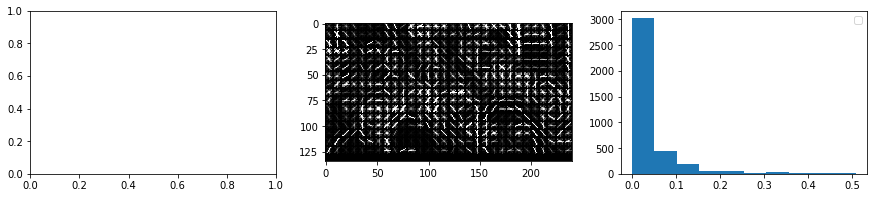

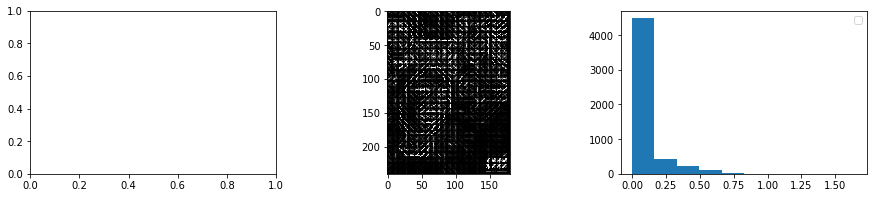

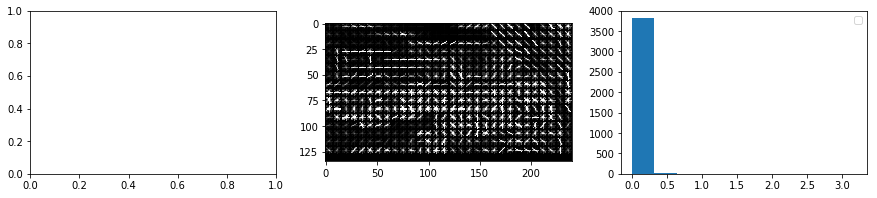

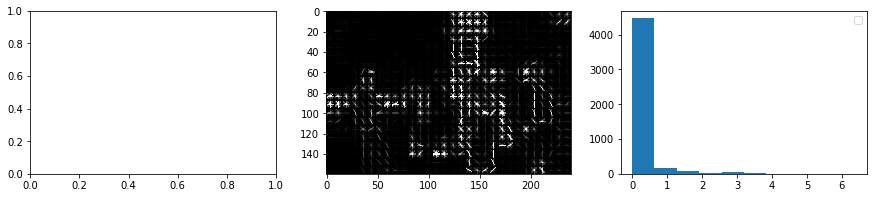

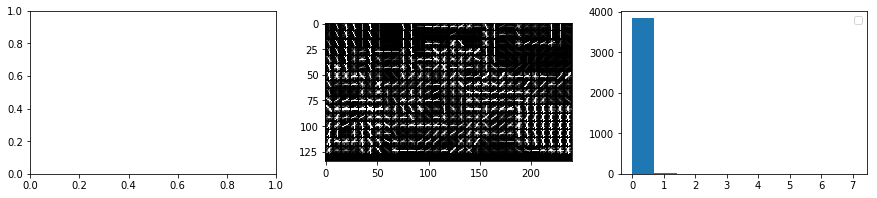

In [112]:
from skimage.feature import hog
from skimage import data, exposure

for i, image in enumerate(images):
    if i in sample_images: 
        grayscale = np.array(image.convert('L'))
        fd, hog_image = hog(grayscale, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), block_norm='L2-Hys', visualise=True)
        
        # rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        plt.figure(figsize=(15, 3))
        plt.subplot(131)
        #plt.imshow(image)
        plt.subplot(132)
        plt.imshow(hog_image_rescaled, cmap='gray')
        plt.subplot(133)
        plt.hist(fd)
        plt.legend()

## Wavelet Transformation

In [325]:
import pywt

for i, image in enumerate(images):
    
    img = np.array(image)
    coeffs = pywt.dwtn(img, 'haar')
    #cA, cD = pywt.dwt(img, 'db1')
    plt.figure()
    print(len(coeffs))
    break


8


[[1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 7.2300e+03 2.3290e+03 4.5370e+03 3.1450e+03
  2.4350e+03 8.5550e+03 3.0630e+03 5.6800e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 6.1240e+03 2.7770e+03 5.6540e+03 3.0010e+03
  2.7630e+03 4.7880e+03 2.0570e+03 3.7980e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.2199e+04 2.5260e+03 4.7930e+03 2.7560e+03
  2.6070e+03 5.1550e+03 2.2490e+03 4.9480e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.1112e+04 3.0280e+03 4.4970e+03 3.0010e+03
  2.0650e+03 6.5580e+03 2.3890e+03 4.4350e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.5103e+04 1.7170e+03 1.8760e+03 6.8340e+03
  1.0230e+03 8.1140e+03 1.1640e+03 1.5040e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.00

# K-means clustering

In [417]:
from sklearn.cluster import KMeans
import re, shutil

kmeans = KMeans(n_clusters=8, random_state=0).fit(X)

images_by_cluster = sorted(zip(images, kmeans.labels_), key=lambda x: x[1]) # create sorted list of (<image>, <cluster>) pairs

base_dir = 'c:/clustering/result/'
shutil.rmtree(base_dir)
for image, cluster in images_by_cluster: # save images in a directory per cluster
    cluster_dir = base_dir + str(cluster)
    if not os.path.exists(cluster_dir):
        os.makedirs(cluster_dir)
    image_name = cluster_dir + '/' + re.split("[/\\\]", image.filename)[-1]
    image.save(image_name, 'JPEG')


#kmeans.labels_
#kmeans.cluster_centers_




## Clustering handwritten digits

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
print(f'Shape = {digits.data.shape}')

import matplotlib.pyplot as plt
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(digits.images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

X = digits.data[:100] # use only the first 100 samples to speed things up
y = digits.target[:100]


Shape = (1797, 64)


### Calculate distance/similarity 

In [276]:
n_samples = X.shape[0]

distanceMatrix = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(n_samples):
        distanceMatrix[i, j] = np.linalg.norm(X[i, :] - X[j, :]) # initialize with euclidean distance
        
# sklearn proposes to use similarity isntead of distance for spectral clustering
beta = .5 # .5 seems to yield the best results, in paper they use 1
similarityMatrix = np.exp(-beta * distanceMatrix / (distanceMatrix.std()**2))  # formula in paper squares the std

### comparison of kmeans & spectral clustering w/ and w/o PCA

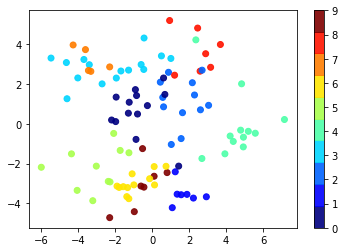

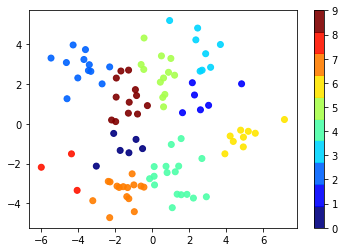

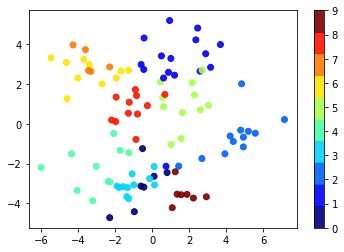

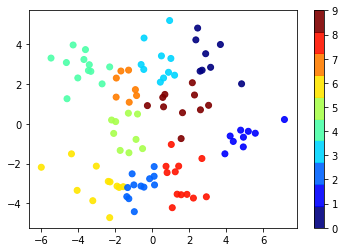

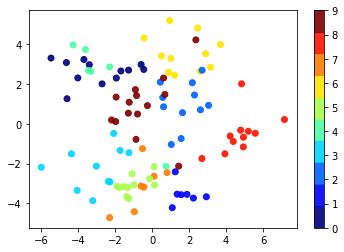

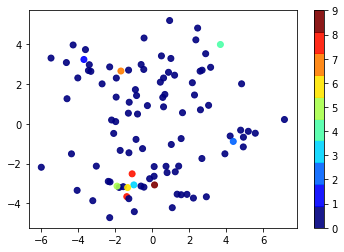

In [206]:

from sklearn.cluster import KMeans, SpectralClustering, spectral_clustering
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from matplotlib import cm

X = scale(X)
Xreduced = PCA(n_components=2).fit_transform(X)

n_clusters = 10


pk = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(X)
pkr = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(Xreduced)
ps = SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors").fit_predict(X)
psr = SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors").fit_predict(Xreduced)
psa = SpectralClustering(n_clusters=n_clusters, affinity="precomputed").fit_predict(similarityMatrix)
psd = spectral_clustering(distanceMatrix,n_clusters=n_clusters) #bad!


cmap = cm.get_cmap('jet', lut=n_clusters)
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=pk, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=pkr, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=ps, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=psr, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=psa, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=psd, cmap=cmap, alpha=.9)
plt.colorbar()



### using affinity matrix described in paper, using euclidean distance to start

## Evaluation

In [207]:
from sklearn import metrics

print(metrics.v_measure_score(y, pk))
print(metrics.v_measure_score(y, pkr))
print(metrics.v_measure_score(y, ps))
print(metrics.v_measure_score(y, psr))
print(metrics.v_measure_score(y, psa))
print(metrics.v_measure_score(y, psd))
# --> clearly we get better results by not reducing the data before clustering! (which was expected)

0.8446550318271264
0.5897815886150143
0.8604297887410008
0.6228096161757998
0.8531536312783682
0.1636009933101447


## Cluster Adjustments

In [248]:
def merge(similarityMatrix, clusters, a, b):
    # expects clusters to be list of labels, a and b label to be merged
    clusters[clusters == b] = a
    for i in range(n_samples):
        for j in range(n_samples):
            if (clusters[i] == clusters[j]):
                similarityMatrix[i,j] = 1 #TODO what exactly should we do here? increase similarity, or set it to fixed val?



{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

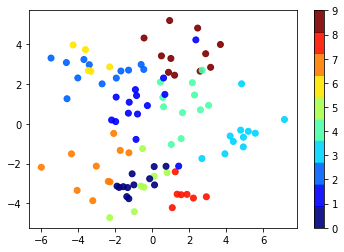

In [278]:
## usecase: merge clusters
n_clusters = 10
p = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=1).fit_predict(similarityMatrix)
cmap = cm.get_cmap('jet', lut=n_clusters)
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=p, cmap=cmap, alpha=.9)
plt.colorbar()

set(p)

In [ ]:
merge(similarityMatrix, p, 0, 5)
print(set(p))

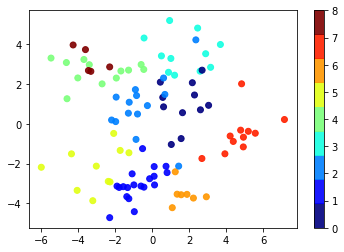

In [284]:
n_clusters = 9
p = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=1).fit_predict(similarityMatrix)
cmap = cm.get_cmap('jet', lut=n_clusters)
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=p, cmap=cmap, alpha=.9)
plt.colorbar()

In [ ]:
merge(similarityMatrix, p, 7, 1)
print(set(p))

{0, 2, 3, 4, 5, 6, 7, 8}


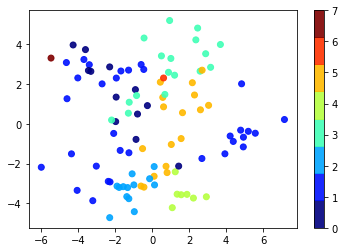

In [274]:
n_clusters = 8
p = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=1).fit_predict(similarityMatrix)
cmap = cm.get_cmap('jet', lut=n_clusters)
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=p, cmap=cmap, alpha=.9)
plt.colorbar()



# The SKlearn example, using kmeans with dimensionality reduction (PCA) for digit clustering

In [101]:

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.28s	69432	0.602	0.650	0.625	0.465	0.598	0.146
random   	0.23s	69694	0.669	0.710	0.689	0.553	0.666	0.147
PCA-based	0.03s	70804	0.671	0.698	0.684	0.561	0.668	0.118
__________________________________________________________________________________


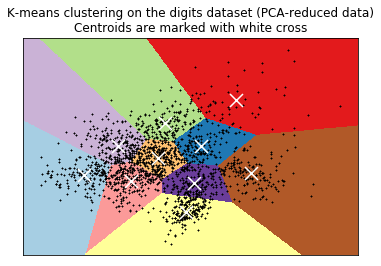

In [133]:
# Visualization

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k+', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()